In [1]:
from gaspy.fireworks_helper_scripts import get_launchpad, get_atoms_from_fwid
from gaspy import gasdb
from gaspy import atoms_operators
from kevin import get_initial_atoms_from_fwid

successfully loaded your custom FW_config.yaml!


In [2]:
import os
import sklearn
import pandas as pd
import matplotlib.pyplot as plt
import scikitplot as skplt
import numpy as np

from extract_features_helpers import *
from parsefile_helpers import *
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.model_selection import train_test_split
from matplotlib.ticker import FuncFormatter, MaxNLocator
from tqdm import tqdm

Using TensorFlow backend.
/global/homes/k/ktran/miniconda3/envs/richie/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/global/homes/k/ktran/miniconda3/envs/richie/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/global/homes/k/ktran/miniconda3/envs/richie/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.in

In [3]:
# making atoms objects from cached files

cache_dir = "/global/cscratch1/sd/zulissi/fireworks_launch_backup"
cached_files = os.listdir(cache_dir)[3000:6000] # test run on 1000 initial candidates
lpad = get_launchpad()

data_dict = {}

for file in tqdm(cached_files):
    launch_id = int(file[:-7])
    launch_fw = list(lpad.launches.find({"launch_id" : launch_id}))[0]
    fw_id = launch_fw["fw_id"]
    atoms = get_initial_atoms_from_fwid(fw_id)
    if len(set(atoms.get_tags())) == 1:
        continue # filter out atoms objects with no tagged adsorbate
    data_dict[file] = {}
    data_dict[file]["atoms"] = atoms

100%|██████████| 3000/3000 [02:16<00:00, 22.04it/s]


In [4]:
# getting features for atoms objects

for file in tqdm(data_dict):
    atoms = data_dict[file]["atoms"]
    features = get_features(atoms)
    data_dict[file]["features"] = features

100%|██████████| 1381/1381 [03:22<00:00,  6.83it/s]


In [5]:
# getting targets for atoms objects

for file in tqdm(data_dict):
    filename = os.path.join(cache_dir, file)
    launch_dir = unzip(filename)
    steptime_coresec = get_steptime_coresec(launch_dir)
    rm_temp(launch_dir)
    data_dict[file]["steptime_coresec"] = steptime_coresec

100%|██████████| 1381/1381 [03:02<00:00,  7.55it/s]


In [6]:
# preprocessing the data

verbose = 1
cutoff = 10000
    
# initializing targets
track_df = pd.DataFrame.from_dict(data_dict).transpose()
Y_list = list(track_df["steptime_coresec"])
target_list = list(map(lambda y: 1 if y > cutoff else 0, Y_list))
track_df["steptime_coresec"] = target_list

# train test split
df_train, df_test = train_test_split(track_df, test_size =0.2)

# making dataframes into lists
X_train = np.array(list(df_train["features"]),dtype=np.float64)
y_train = np.array(list(df_train["steptime_coresec"]),dtype=np.float64)
X_test = np.array(list(df_test["features"]),dtype=np.float64)
y_test = np.array(list(df_test["steptime_coresec"]),dtype=np.float64)
if verbose:
    print("unbalanced shapes:", X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# preprocessing
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(np.concatenate((X_train, X_test)))
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# resampling using ADASYN
X_resampled, y_resampled = ADASYN().fit_resample(X_train, y_train)
if verbose:
    print("resampled shapes:", X_resampled.shape, y_resampled.shape)

unbalanced shapes: (1104, 10) (277, 10) (1104,) (277,)
resampled shapes: (2106, 10) (2106,)


In [7]:
# training and testing data

# fitting KNeighborsClassifier model
model = KNeighborsClassifier(weights="uniform", algorithm="auto", n_jobs=4, n_neighbors=11, leaf_size=30)
model.fit(X_resampled, y_resampled)

# predicting with the model
y_predict = model.predict(X_test)
accuracy = sklearn.metrics.accuracy_score(y_test, y_predict)
balanced_accuracy = sklearn.metrics.balanced_accuracy_score(y_test, y_predict)
recall = sklearn.metrics.recall_score(y_test, y_predict)
if verbose:
    print("accuracy:", accuracy, "\nbalanced accuracy:", balanced_accuracy, "\nrecall:", recall)

accuracy: 0.7978339350180506 
balanced accuracy: 0.851161995898838 
recall: 0.9090909090909091


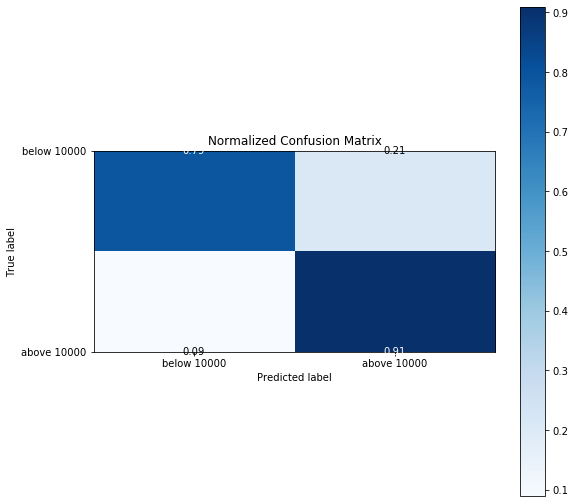

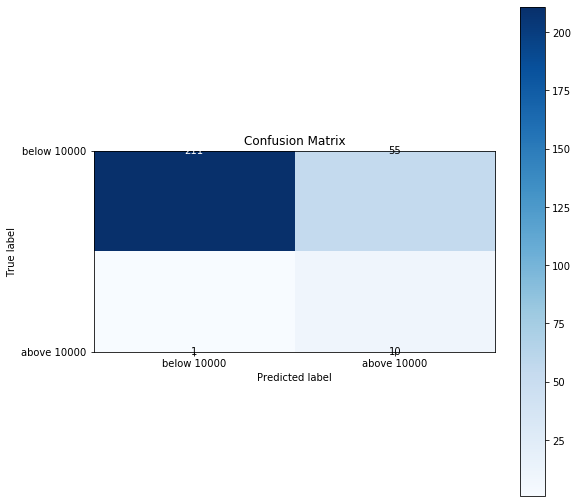

In [8]:
# plotting confusion matrices

if verbose:
    plt.rcParams["figure.figsize"] = [9,9]
    ax1 = skplt.metrics.plot_confusion_matrix(y_test, y_predict, normalize=True)
    ax2 = skplt.metrics.plot_confusion_matrix(y_test, y_predict, normalize=False)
    labels = ["below %d"%cutoff, "above %d"%cutoff]

    def format_fn(tick_val, tick_pos):
        return labels[tick_val]

    ax1.xaxis.set_major_formatter(FuncFormatter(format_fn))
    ax1.yaxis.set_major_formatter(FuncFormatter(format_fn))
    ax2.xaxis.set_major_formatter(FuncFormatter(format_fn))
    ax2.yaxis.set_major_formatter(FuncFormatter(format_fn))